# 1D VTI comparison between `emg3d` and `empymod`

The code `empymod` is an open-source code which can model CSEM responses for a layered medium including VTI electrical anisotropy, see https://empymod.github.io.

1. **Full-space model for a finite length, finite strength, rotated bipole.**  
   1.1 Regular VTI case  
   1.2 Tri-axial anisotropy check: Swap `x` and `z` in `emg3d`; compare `yz`-slice  
   1.3 Tri-axial anisotropy check: Swap `y` and `z` in `emg3d`; compare `xz`-slice
2. **Layered model for a deep water model with a point dipole source.**


#### Requires
- ``emg3d``, ``discretize``, ``empymod``
- ``numpy``, ``scipy``, ``numba``, ``matplotlib``

In [1]:
import discretize
import numpy as np
import empymod as epm
import matplotlib.pyplot as plt
from scipy import interpolate as sint
from matplotlib.colors import LogNorm, SymLogNorm

import emg3d as e3d

In [2]:
# Style adjustments
%matplotlib inline
plt.style.use('ggplot')

### Plotting and interpolation routines

In [3]:
def interpn(grid, field, rx, ry, rz, rdir='x'):
    """Simple interpolation function for emg3d.
    
    Could probably be achieved with discretize:
    
        P = grid.getInterpolationMat(
            getattr(newgrid, 'gridE'+rdir, locType='E'+rdir)
        return P*getattr(field, 'f'+rdir).ravel('F')
    
    """
    if rdir == 'y':
        inp = (grid.vectorNx, grid.vectorCCy, grid.vectorNz)
    elif rdir == 'z':
        inp = (grid.vectorNx, grid.vectorNy, grid.vectorCCz)
    else:  # Default is 'x'
        inp = (grid.vectorCCx, grid.vectorNy, grid.vectorNz)
        
    return sint.interpn(inp, getattr(field, 'f'+rdir), (rx, ry, rz))

In [4]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map
    https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    """
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


def plot_data_rel(ax, name, data, x, vmin=-15., vmax=-7., mode="log"):
    """Plot function."""
    
    ax.set_title(name)
    ax.set_xlim(min(x)/1000, max(x)/1000)
    ax.set_ylim(min(x)/1000, max(x)/1000)
    ax.axis("equal")
    
    if isinstance(mode, str):
        if mode == "abs":
            cf = ax.pcolormesh(x/1000, x/1000, np.log10(np.abs(data)), linewidth=0,
                               rasterized=True, cmap="viridis", vmin=vmin, vmax=vmax)
        else:
            cf = ax.pcolormesh(x/1000, x/1000, data, linewidth=0, rasterized=True, cmap="PuOr_r",
                               norm=SymLogNorm(linthresh=10**vmin, vmin=-10**vmax, vmax=10**vmax))
    else:
        cf = ax.pcolormesh(x/1000, x/1000, np.log10(data), vmin=vmin, vmax=vmax,
                           linewidth=0, rasterized=True, cmap=discrete_cmap(8, "RdBu_r"))

    return cf


def plot_result_rel(depm, de3d, x, title, vmin=-15., vmax=-7., mode="log"):
    fig, axs = plt.subplots(figsize=(18, 10), nrows=2, ncols=3)
    
    if mode == "log":
        case = ""
    else:
        case = "|"

    # Plot Re(data)
    cf0 = plot_data_rel(axs[0, 0], r"(a) "+case+"Re(empymod)"+case, depm.real, x, vmin, vmax, mode)
    plot_data_rel(axs[0, 1], r"(b) "+case+"Re(emg3d)"+case, de3d.real, x, vmin, vmax, mode)
    cf2 = plot_data_rel(axs[0, 2], r"(c) Error real part",
                        np.abs((depm.real-de3d.real)/depm.real)*100, x,
                        vmin=-2, vmax=2, mode=True)

    # Plot Im(data)
    plot_data_rel(axs[1, 0], r"(d) "+case+"Im(empymod)"+case, depm.imag, x, vmin, vmax, mode)
    plot_data_rel(axs[1, 1], r"(e) "+case+"Im(emg3d)"+case, de3d.imag, x, vmin, vmax, mode)
    plot_data_rel(axs[1, 2], r"(f) Error imaginary part",
                  np.abs((depm.imag-de3d.imag)/depm.imag)*100, x, vmin=-2, vmax=2, mode=True)

    # Colorbars
    fig.colorbar(cf0, ax=axs[0, :], label=r"$\log_{10}$ Amplitude (V/m)")
    cbar = fig.colorbar(cf2, ax=axs[1, :], label=r"Relative Error")
    cbar.set_ticks([-2, -1, 0, 1, 2])
    cbar.ax.set_yticklabels([r"$0.01\,\%$", r"$0.1\,\%$", r"$1\,\%$", r"$10\,\%$", r"$100\,\%$"])

    # Axis label
    fig.text(0.4, 0.05, "Inline Offset (km)", fontsize=14)
    fig.text(0.08, 0.6, "Crossline Offset (km)", rotation=90, fontsize=14)

    # Title
    fig.suptitle(title, y=1, fontsize=20)

    
def plot_lineplot_ex(x, y, data, epm_fs, grid):
    xi = x.size//2
    yi = y.size//2
    
    fn = sint.interp1d(x, data[:, xi], bounds_error=False)
    x1 = fn(grid.vectorNx)
    
    fn = sint.interp1d(y, data[yi, :], bounds_error=False)
    y1 = fn(grid.vectorNx)

    plt.figure(figsize=(15, 8))
    
    plt.plot(x/1e3, np.abs(epm_fs[:, xi]), 'C0', lw=3, label='Inline empymod')
    plt.plot(x/1e3, np.abs(data[:, xi]), 'k--', label='Inline emg3d')
    plt.plot(grid.vectorNx/1e3, np.abs(x1), 'k*')
    
    plt.plot(y/1e3, np.abs(epm_fs[yi, :]), 'C1', lw=3, label='Crossline empymod')
    plt.plot(y/1e3, np.abs(data[yi, :]), 'k:', label='Crossline emg3d')
    plt.plot(grid.vectorNx/1e3, np.abs(y1), 'k*', label='Grid points emg3d')

    plt.yscale('log')
    plt.title(r'Inline and crossline $E_x$', fontsize=20)
    plt.xlabel('Offset (km)', fontsize=14)
    plt.ylabel(r'|Amplitude (V/m)|', fontsize=14)
    plt.legend()
    plt.show()

## 1. Full-space model for a finite length, finite strength, rotated bipole 

### 1.1 Regular VTI case

### `empymod`

In [5]:
# Survey parameters
x = (np.arange(1025))*5-2560
rx = np.repeat([x,],np.size(x),axis=0)
ry = rx.transpose()

# Model parameters
resh = 1.              # Horizontal resistivity
aniso = np.sqrt(2.)    # Anisotropy
resv = resh*aniso**2   # Vertical resistivity
src = [-50, 50, -30, 30, -320., -280.]  # Source: [x1, x2, y1, y2, z1, z2]
src_c = np.mean(np.array(src).reshape(3, 2), 1).ravel()  # Center points of course
zrec = -400.           # Receiver depth
freq = 0.77            # Frequency
strength = np.pi       # Source strength

# Input for empymod
model = {  # empymod has positive z-down, so switch source-z
    'src': [src[0], src[1], src[2], src[3], -src[4], -src[5]],
    'depth': [],
    'res': resh,
    'aniso': aniso,
    'strength': strength,
    'srcpts': 5,
    'freqtime': freq,
    'htarg': {'pts_per_dec': -1},
}

In [6]:
epm_fs_x = epm.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 0, 0], verb=3, **model).reshape(np.shape(rx))
epm_fs_y = epm.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 90, 0], verb=1, **model).reshape(np.shape(rx))
epm_fs_z = epm.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 0, -90], verb=1, **model).reshape(np.shape(rx))


:: empymod START  ::

   depth       [m] :  
   res     [Ohm.m] :  1
   aniso       [-] :  1.41421
   epermH      [-] :  1
   epermV      [-] :  1
   mpermH      [-] :  1
   mpermV      [-] :  1

>  MODEL IS A FULLSPACE
   direct field    :  Calc. in wavenumber domain
   frequency  [Hz] :  0.77
   Hankel          :  DLF (Fast Hankel Transform)
     > Filter      :  Key 201 (2009)
     > DLF type    :  Lagged Convolution
   Kernel Opt.     :  None
   Loop over       :  Frequencies
   Source(s)       :  1 bipole(s)
     > intpts      :  5
     > length  [m] :  123.288
     > strength[A] :  3.14159
     > x_c     [m] :  0
     > y_c     [m] :  0
     > z_c     [m] :  300
     > azimuth [°] :  30.9638
     > dip     [°] :  -18.9318
   Receiver(s)     :  1050625 dipole(s)
     > x       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > y       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > z       [m] :  400
     > azimuth [°] :  0
     > dip     [°] :  0
   Required ab's   : 

### `emg3d`

In [7]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = e3d.utils.get_domain(x0=src[0], freq=0.1, min_width=20)
hz_min, zdomain = e3d.utils.get_domain(x0=src[2], freq=0.1, min_width=20)

# Create stretched grid
nx = 2**7
hx = e3d.utils.get_stretched_h(hx_min, xdomain, nx, src_c[0])
hy = e3d.utils.get_stretched_h(hx_min, xdomain, nx, src_c[1])
hz = e3d.utils.get_stretched_h(hz_min, zdomain, nx, src_c[2])
pgrid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
pgrid

TensorMesh: 2,097,152 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128     -4,408.71      4,228.19     20.00    160.52    1.03
   y    128     -4,408.71      4,228.19     20.00    160.52    1.03
   z    128     -4,388.71      4,249.67     20.00    165.56    1.03

In [8]:
# Get the model
pmodel = e3d.utils.Model(pgrid, res_x=resh, res_z=resv, freq=freq)

# Get the source field
sfield = e3d.utils.get_source_field(pgrid, src, freq, strength)

# Calculate the electric field
pfield = e3d.solver.solver(pgrid, pmodel, sfield, verb=3)


:: emg3d START :: 10:28:17 ::

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : False [0]           tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x 128     => 2,097,152 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   6   

   [hh:mm:ss]     error                 l2:[last/init, last/prev] l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [10:28:31] 1.867e-05 after  1 F-cycles; [2.861e-02, 2.861e-02] 0 0
   [10:28:43] 1.494e-06 after  2 F-cycles; [2.289e-03, 8.001e-02] 0 0
   [10:28:56] 1.753e-07 after  3 F-cycles; [2.686e-04

### Plot

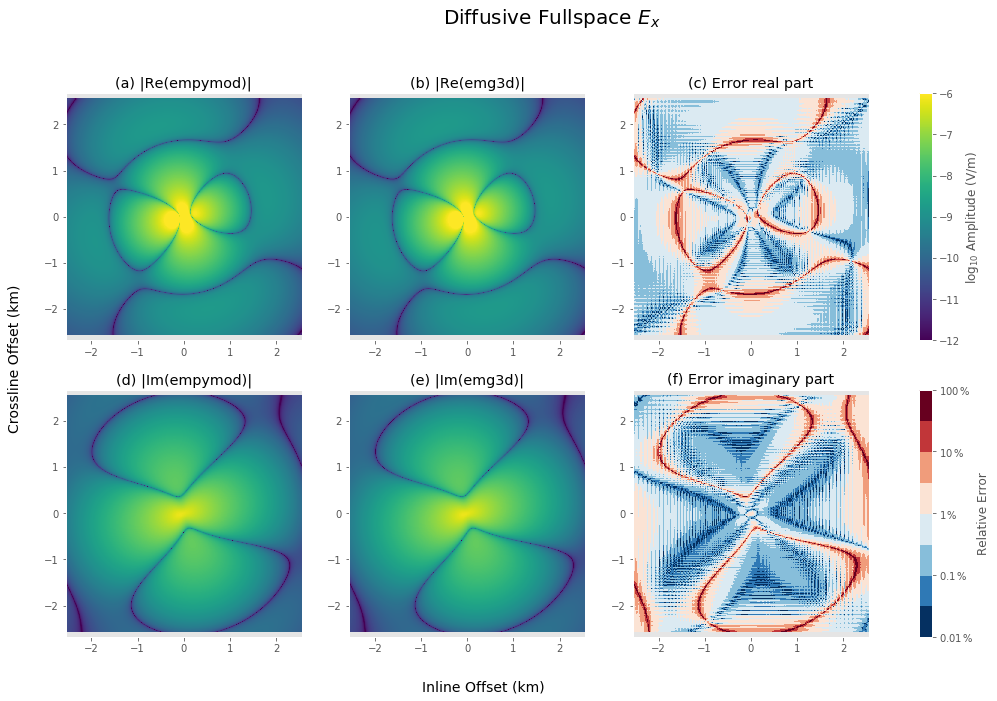

In [9]:
e3d_fs_x = interpn(pgrid, pfield, rx, ry, zrec, 'x')
plot_result_rel(epm_fs_x, e3d_fs_x, x, r'Diffusive Fullspace $E_x$', vmin=-12, vmax=-6, mode='abs')

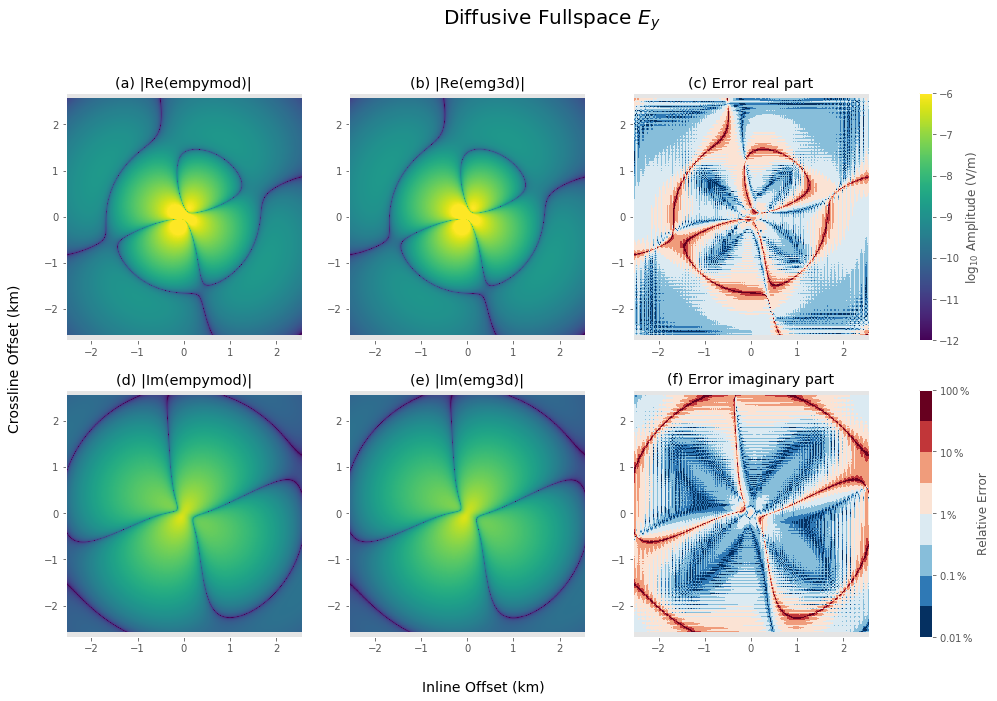

In [10]:
e3d_fs_y = interpn(pgrid, pfield, rx, ry, zrec, 'y')
plot_result_rel(epm_fs_y, e3d_fs_y, x, r'Diffusive Fullspace $E_y$', vmin=-12, vmax=-6, mode='abs')

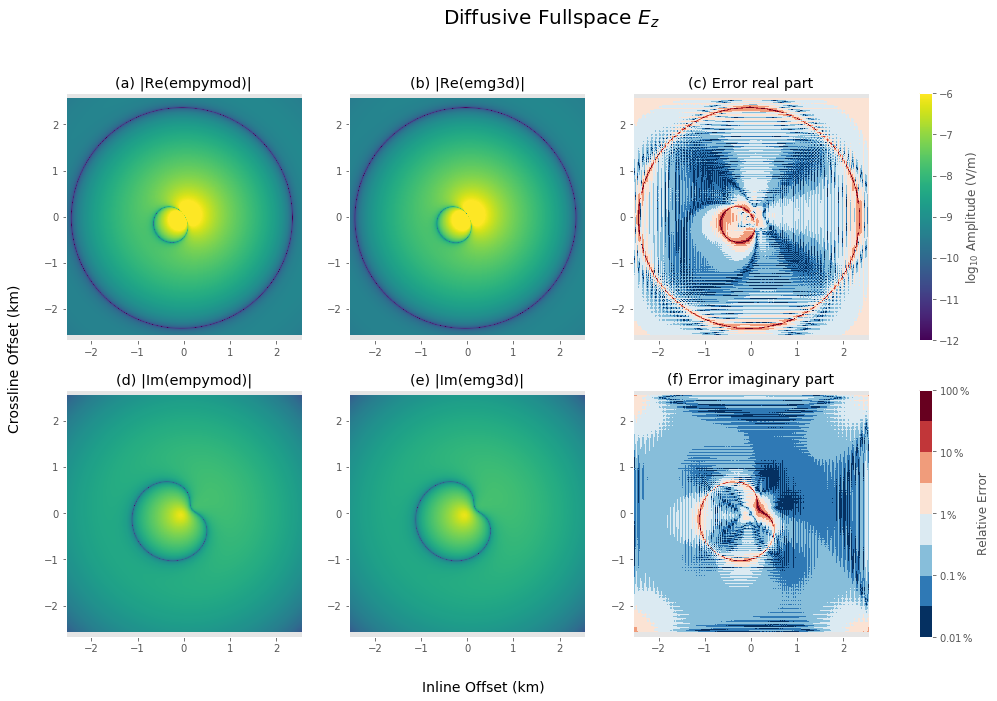

In [11]:
e3d_fs_z = interpn(pgrid, pfield, rx, ry, zrec, 'z')
plot_result_rel(epm_fs_z, e3d_fs_z, x, r'Diffusive Fullspace $E_z$', vmin=-12, vmax=-6, mode='abs')

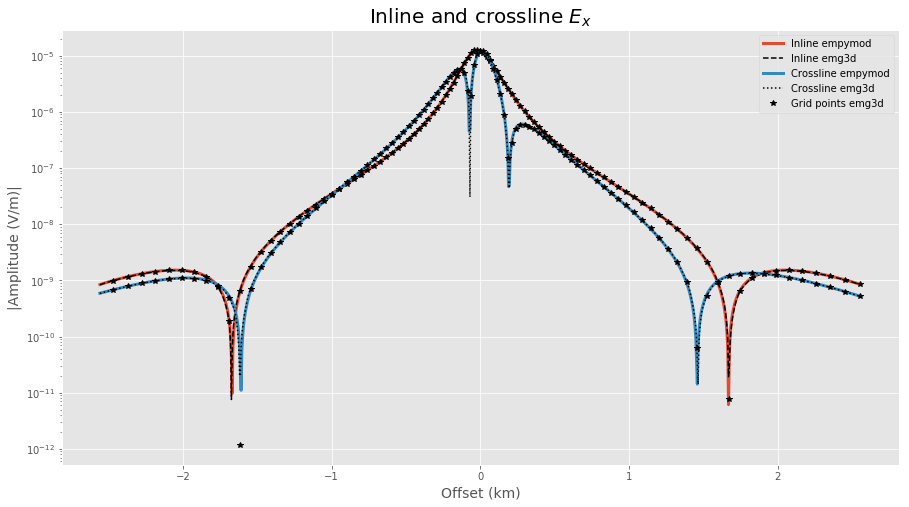

In [12]:
plot_lineplot_ex(x, x, e3d_fs_x.real, epm_fs_x.real, pgrid)

### 1.2 Tri-axial anisotropy check: Swap `x` and `z` in `emg3d`; compare `yz`-slice

`empymod` can handle VTI, but not tri-axial anisotropy. To verify tri-axial anisotropy in `emg3d`, we swap the `x` and `z` axes, and compare the `xy`-`empymod` result to the `zy`-`emg3d` result.


:: emg3d START :: 10:30:31 ::

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : False [0]           tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x 128     => 2,097,152 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   6   

   [hh:mm:ss]     error                 l2:[last/init, last/prev] l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [10:30:44] 1.805e-05 after  1 F-cycles; [2.765e-02, 2.765e-02] 0 0
   [10:30:56] 1.474e-06 after  2 F-cycles; [2.258e-03, 8.167e-02] 0 0
   [10:31:08] 1.747e-07 after  3 F-cycles; [2.676e-04

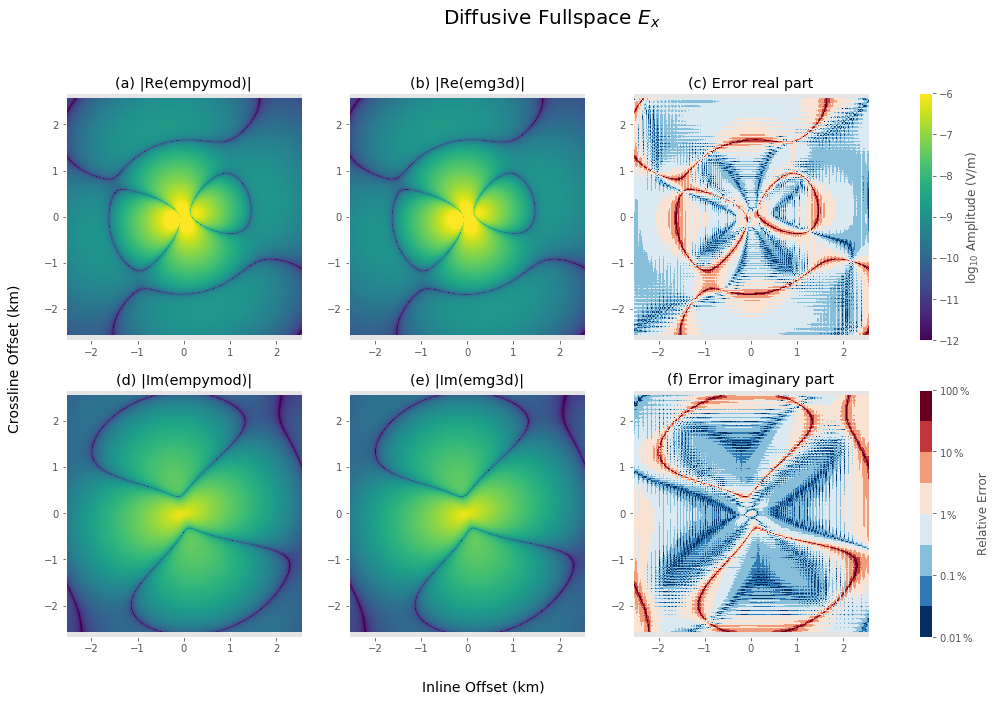

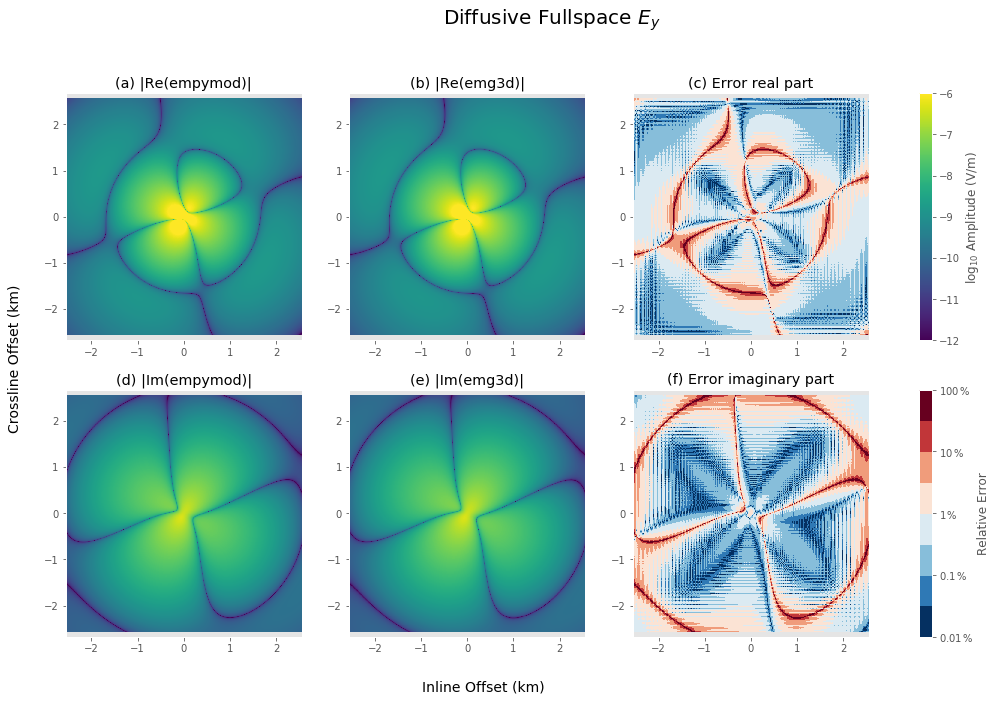

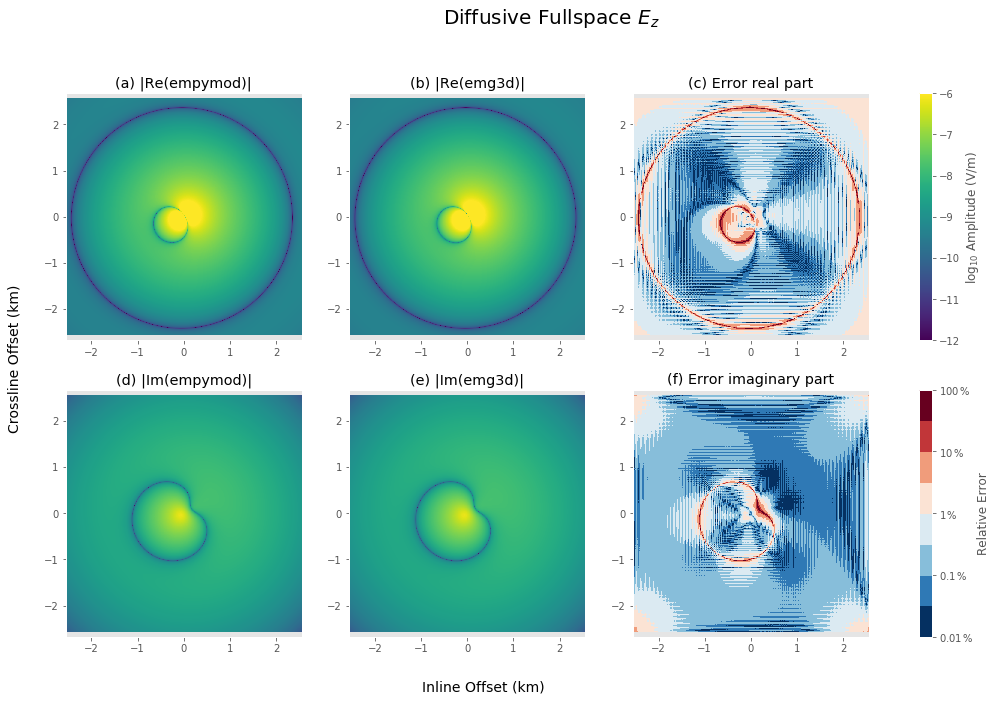

In [13]:
# ===> Swap hy and hz; ydomain and zdomain <===
pgrid = discretize.TensorMesh([hx, hz, hy], x0=(xdomain[0], zdomain[0], xdomain[0]))

# ===> Swap y- and z-resistivities <===
pmodel = e3d.utils.Model(pgrid, res_x=resh, res_y=resv, freq=freq)

# ===> Swap src_y and src_z <===
src_new = [src[0], src[1], src[4], src[5], src[2], src[3]]

sfield = e3d.utils.get_source_field(pgrid, src_new, freq, strength)
pfield = e3d.solver.solver(pgrid, pmodel, sfield, verb=3)

# ===> Swap ry and zrec <===
e3d_fs_x = interpn(pgrid, pfield, rx, zrec, ry, 'x')
plot_result_rel(epm_fs_x, e3d_fs_x, x, r'Diffusive Fullspace $E_x$', vmin=-12, vmax=-6, mode='abs')

# ===> Swap ry and zrec; 'y'->'z' <===
e3d_fs_y = interpn(pgrid, pfield, rx, zrec, ry, 'z')
plot_result_rel(epm_fs_y, e3d_fs_y, x, r'Diffusive Fullspace $E_y$', vmin=-12, vmax=-6, mode='abs')

# ===> Swap ry and zrec; 'z'->'y' <===
e3d_fs_z = interpn(pgrid, pfield, rx, zrec, ry, 'y')
plot_result_rel(epm_fs_z, e3d_fs_z, x, r'Diffusive Fullspace $E_z$', vmin=-12, vmax=-6, mode='abs')

### 1.3 Tri-axial anisotropy check: Swap `y` and `z` in `emg3d`; compare `xz`-slice

`empymod` can handle VTI, but not tri-axial anisotropy. To verify tri-axial anisotropy in `emg3d`, we swap the `y` and `z` axes, and compare the `xy`-`empymod` result to the `xz`-`emg3d` result.


:: emg3d START :: 10:32:54 ::

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : False [0]           tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x 128     => 2,097,152 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   6   

   [hh:mm:ss]     error                 l2:[last/init, last/prev] l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [10:33:08] 1.429e-05 after  1 F-cycles; [2.189e-02, 2.189e-02] 0 0
   [10:33:21] 1.359e-06 after  2 F-cycles; [2.082e-03, 9.510e-02] 0 0
   [10:33:36] 1.740e-07 after  3 F-cycles; [2.666e-04

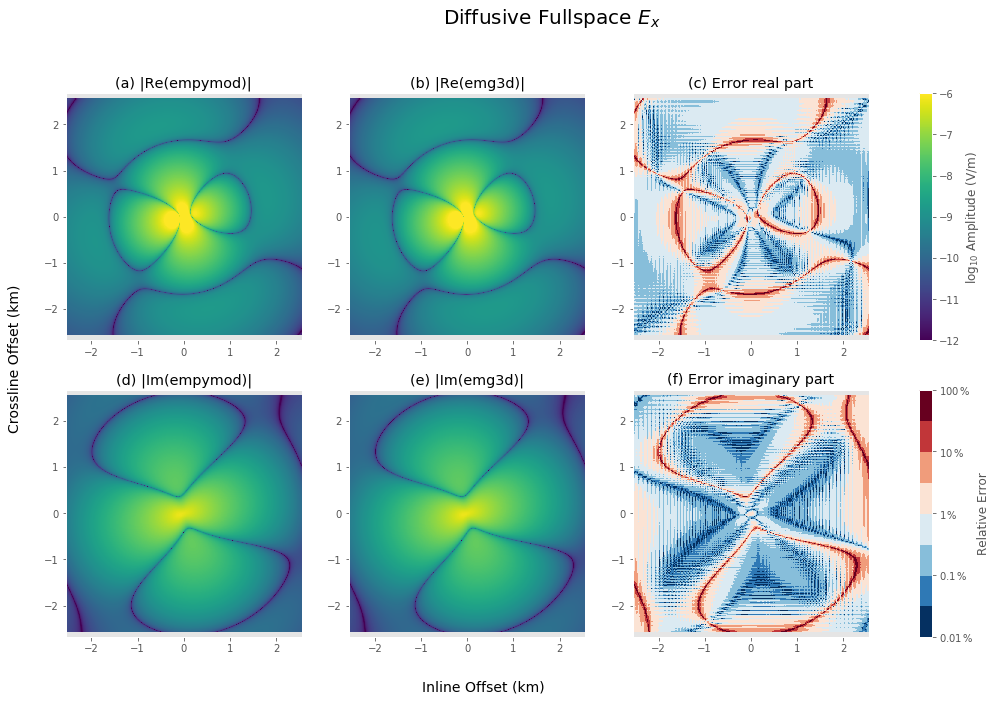

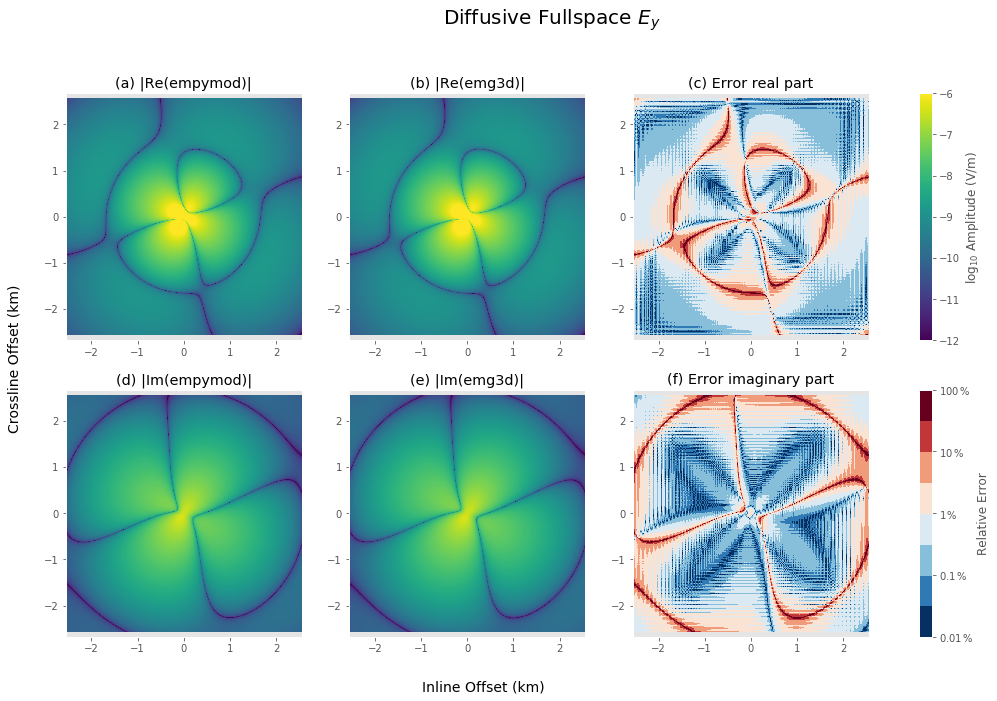

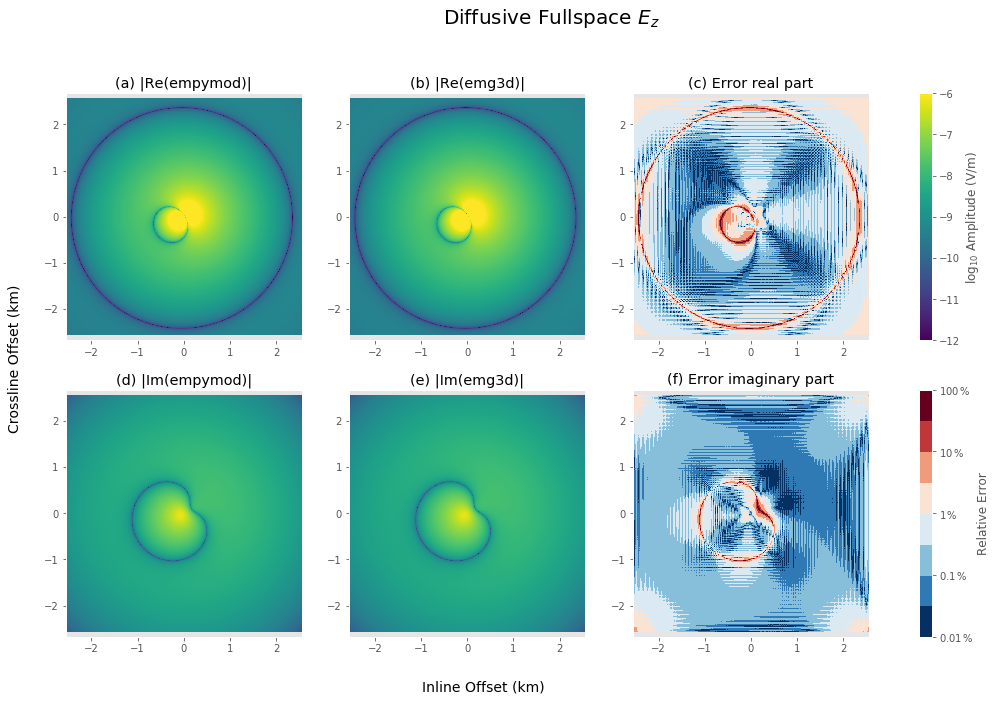

In [14]:
# ===> Swap hx and hz; xdomain and zdomain <===
pgrid = discretize.TensorMesh([hz, hy, hx], x0=(zdomain[0], xdomain[0], xdomain[0]))

# ===> Swap x- and z-resistivities <===
pmodel = e3d.utils.Model(pgrid, resv, resh, resh, freq)

# ===> Swap src_x and src_z <===
src_new = [src[4], src[5], src[2], src[3], src[0], src[1]]

sfield = e3d.utils.get_source_field(pgrid, src_new, freq, strength)
pfield = e3d.solver.solver(pgrid, pmodel, sfield, verb=3)

# ===> Swap rx and zrec; 'x'->'z' <===
e3d_fs_x = interpn(pgrid, pfield, zrec, ry, rx, 'z')
plot_result_rel(epm_fs_x, e3d_fs_x, x, r'Diffusive Fullspace $E_x$', vmin=-12, vmax=-6, mode='abs')

# ===> Swap rx and zrec <===
e3d_fs_y = interpn(pgrid, pfield, zrec, ry, rx, 'y')
plot_result_rel(epm_fs_y, e3d_fs_y, x, r'Diffusive Fullspace $E_y$', vmin=-12, vmax=-6, mode='abs')

# ===> Swap rx and zrec; 'z'->'x' <===
e3d_fs_z = interpn(pgrid, pfield, zrec, ry, rx, 'x')
plot_result_rel(epm_fs_z, e3d_fs_z, x, r'Diffusive Fullspace $E_z$', vmin=-12, vmax=-6, mode='abs')

## 2. Layered model for a deep water model with a point dipole source.

### `empymod`

In [15]:
# Survey parameters
x = (np.arange(1025))*5-2560
rx = np.repeat([x,], np.size(x), axis=0)
ry = rx.transpose()

# Model parameters
resh = [2e14, 0.3, 1, 50, 1]      # Horizontal resistivity
aniso = np.sqrt([1, 1, 2, 2, 2])  # Anisotropy
resv = resh*aniso**2              # Vertical resistivity
src = [0, 0, -900, 0, 0]          # Source: [x, y, z, azimuth, dip]
zrec = -950.                      # Receiver depth
freq = 1                          # Frequency
depth = np.array([0, -1000, -2000, -2200])  # Layer boundaries

model = {  # empymod has positive z-down, so switch source-z
    'src': [src[0], src[1], -src[2], src[3], src[4]],
    'depth': -depth,
    'res': resh,
    'aniso': aniso,
    'freqtime': freq,
    'htarg': {'pts_per_dec': -1},
}

In [16]:
epm_deep_x = epm.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 0, 0], verb=3, **model).reshape(np.shape(rx))
epm_deep_y = epm.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 90, 0], verb=1, **model).reshape(np.shape(rx))
epm_deep_z = epm.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 0, -90], verb=1, **model).reshape(np.shape(rx))


:: empymod START  ::

   depth       [m] :  0 1000 2000 2200
   res     [Ohm.m] :  2E+14 0.3 1 50 1
   aniso       [-] :  1 1 1.41421 1.41421 1.41421
   epermH      [-] :  1 1 1 1 1
   epermV      [-] :  1 1 1 1 1
   mpermH      [-] :  1 1 1 1 1
   mpermV      [-] :  1 1 1 1 1
   direct field    :  Calc. in wavenumber domain
   frequency  [Hz] :  1
   Hankel          :  DLF (Fast Hankel Transform)
     > Filter      :  Key 201 (2009)
     > DLF type    :  Lagged Convolution
   Kernel Opt.     :  None
   Loop over       :  Frequencies
   Source(s)       :  1 dipole(s)
     > x       [m] :  0
     > y       [m] :  0
     > z       [m] :  900
     > azimuth [°] :  0
     > dip     [°] :  0
   Receiver(s)     :  1050625 dipole(s)
     > x       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > y       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > z       [m] :  950
     > azimuth [°] :  0
     > dip     [°] :  0
   Required ab's   :  11
* WARNING :: Offsets < 0.001 m are set

### `emg3d`

In [17]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = e3d.utils.get_domain(x0=src[0], freq=0.1, min_width=20)
hz_min, zdomain = e3d.utils.get_domain(x0=src[2], freq=0.1, min_width=20, fact_pos=10)

# Create stretched grid
nx = 2**7
hx = e3d.utils.get_stretched_h(hx_min, xdomain, nx, src[0])
hy = e3d.utils.get_stretched_h(hx_min, xdomain, nx, src[1])
hz = e3d.utils.get_stretched_h(hz_min, zdomain, nx*2, x0=depth[-1], x1=0)
pgrid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
pgrid

TensorMesh: 4,194,304 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128     -4,358.71      4,505.64     20.00    166.93    1.03
   y    128     -4,358.71      4,505.64     20.00    166.93    1.03
   z    256     -5,258.71      7,568.16     20.00    229.22    1.03

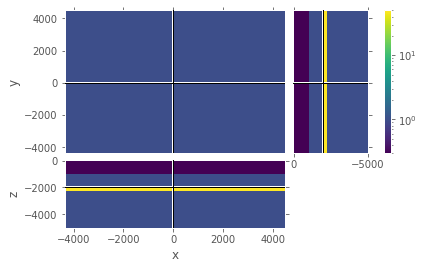

In [18]:
# Create the model: horizontal resistivity
res_x_full =  resh[-1]*np.ones(pgrid.nC)  # Background
res_x_full[pgrid.gridCC[:, 2] >= depth[3]] = resh[3]  # Target
res_x_full[pgrid.gridCC[:, 2] >= depth[2]] = resh[2]  # Overburden
res_x_full[pgrid.gridCC[:, 2] >= depth[1]] = resh[1]  # Water
res_x_full[pgrid.gridCC[:, 2] >= depth[0]] = resh[0]  # Air

# Create the model: vertical resistivity
res_z_full =  resv[-1]*np.ones(pgrid.nC)  # Background
res_z_full[pgrid.gridCC[:, 2] >= depth[3]] = resv[3]
res_z_full[pgrid.gridCC[:, 2] >= depth[2]] = resv[2]
res_z_full[pgrid.gridCC[:, 2] >= depth[1]] = resv[1]
res_z_full[pgrid.gridCC[:, 2] >= depth[0]] = resv[0]

# Get the model
pmodel = e3d.utils.Model(pgrid, res_x_full, res_z=res_z_full, freq=freq)

# Plot it
pgrid.plot_3d_slicer(pmodel.res_x, zslice=-2000, clim=[0.3, 50], zlim=(-5000, 50), pcolorOpts={'norm': LogNorm()})

In [19]:
# Get the source field
sfield = e3d.utils.get_source_field(pgrid, src, freq, 0)

# Calculate the electric field
pfield = e3d.solver.solver(pgrid, pmodel, sfield, verb=3)


:: emg3d START :: 10:36:12 ::

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : False [0]           tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x 256     => 4,194,304 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   7   

   [hh:mm:ss]     error                 l2:[last/init, last/prev] l s

       h_
      2h_ \                                                      /
      4h_  \                                        /\          / 
      8h_   \                            /\        /  \        /  
     16h_    \                  /\      /  \      /    \      /   
     32h_     \          /\    /  \    /    \    /      \    /    
     64h_      \    /\  /  \  /    \  /      \  /        \  /     
    128h_       \/\/  \/    \/      \/        \/          \/      

   [10:36:36] 1.444e-07 after  1 F-cycles;

### Plot

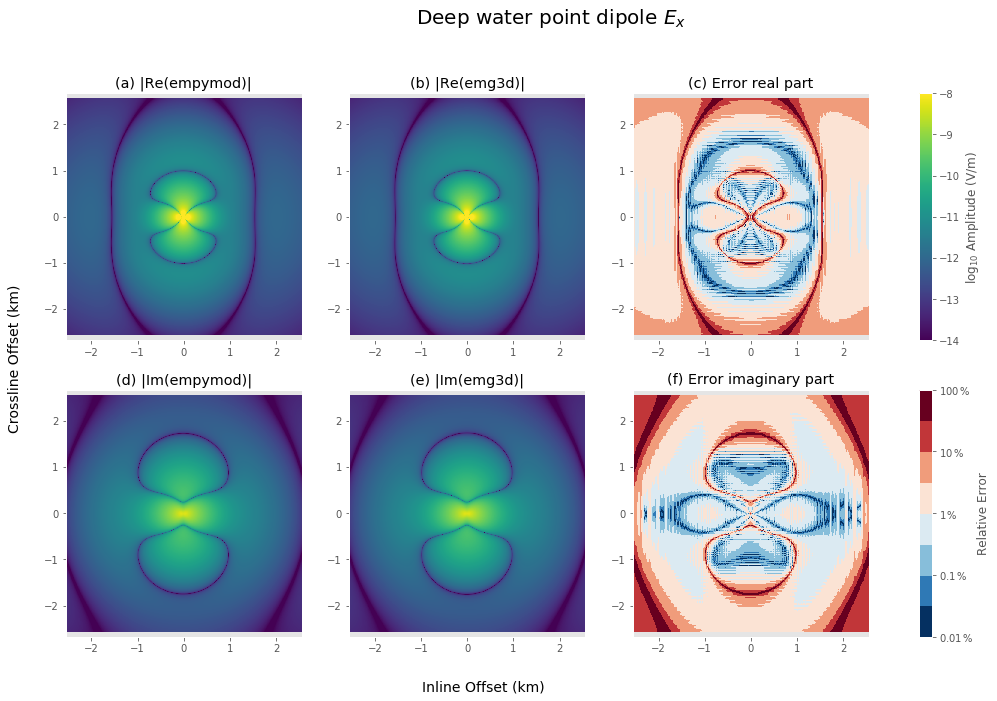

In [20]:
e3d_deep_x = interpn(pgrid, pfield, rx, ry, zrec, 'x')
plot_result_rel(epm_deep_x, e3d_deep_x, x, r'Deep water point dipole $E_x$', vmin=-14, vmax=-8, mode='abs')

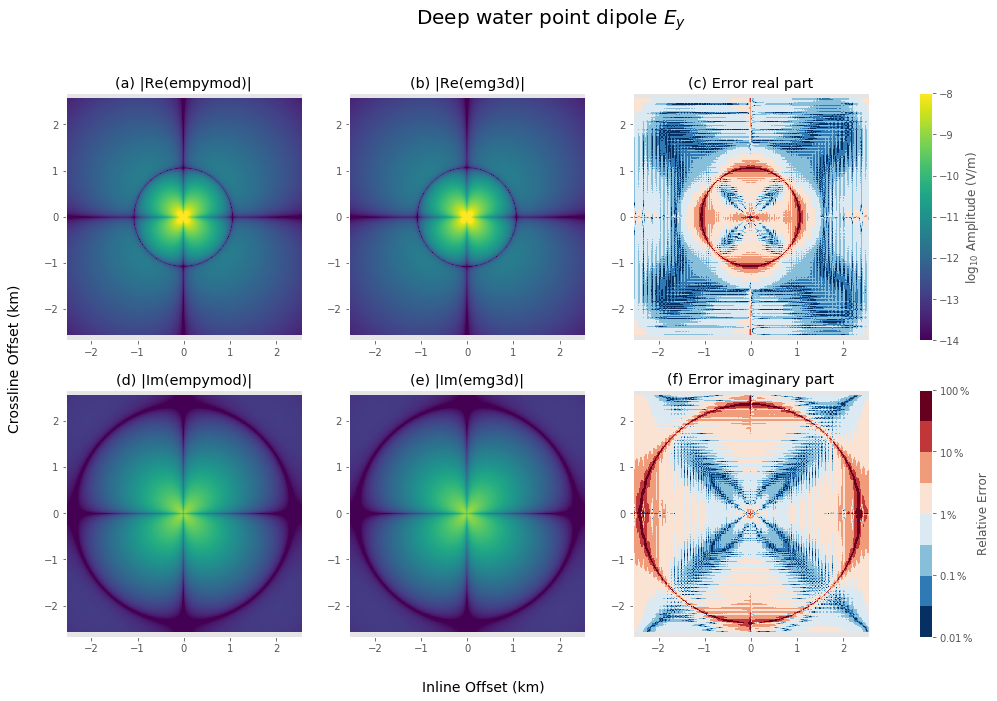

In [21]:
e3d_deep_y = interpn(pgrid, pfield, rx, ry, zrec, 'y')
plot_result_rel(epm_deep_y, e3d_deep_y, x, r'Deep water point dipole $E_y$', vmin=-14, vmax=-8, mode='abs')

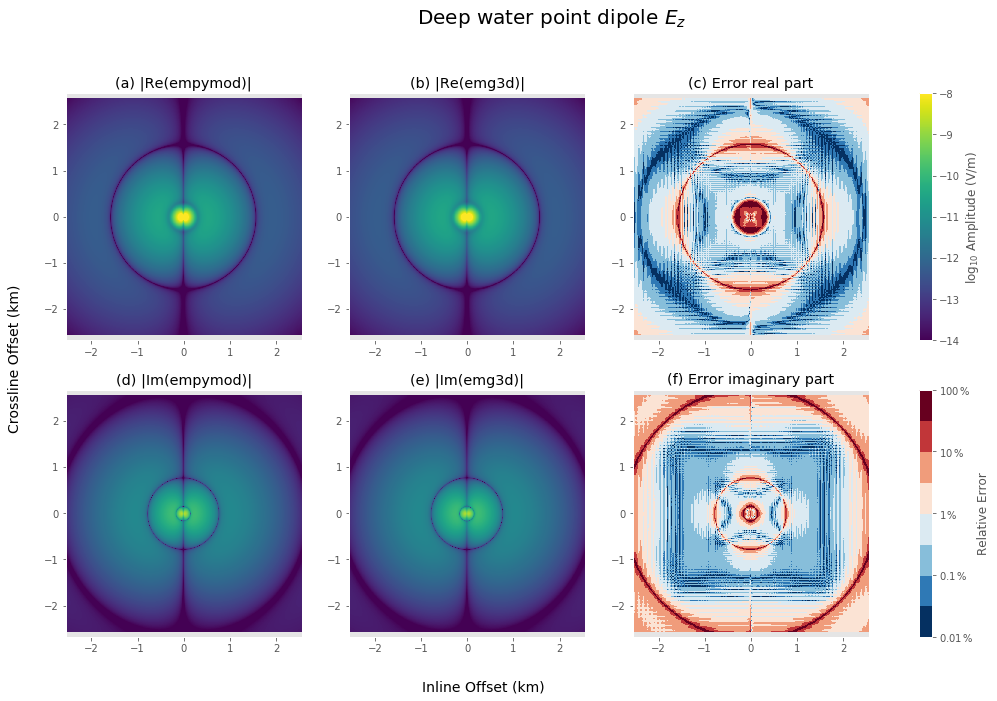

In [22]:
e3d_deep_z = interpn(pgrid, pfield, rx, ry, zrec, 'z')
plot_result_rel(epm_deep_z, e3d_deep_z, x, r'Deep water point dipole $E_z$', vmin=-14, vmax=-8, mode='abs')

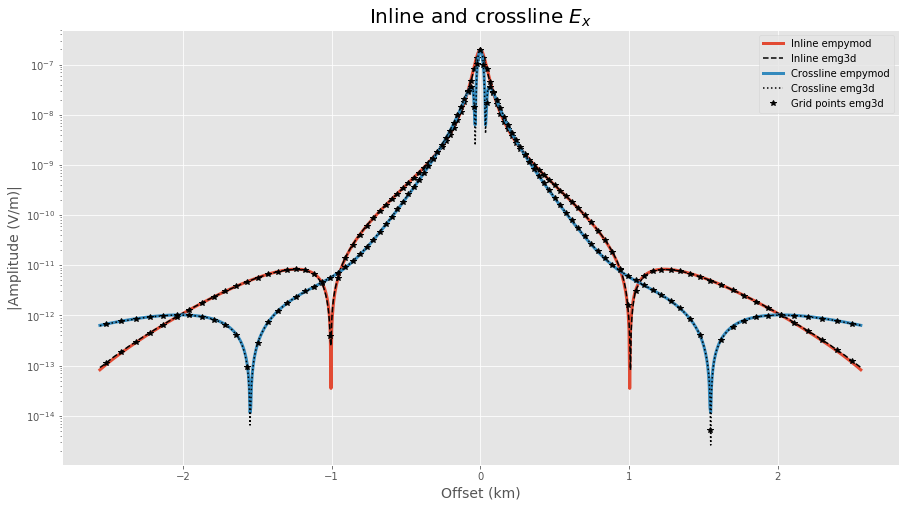

In [23]:
plot_lineplot_ex(x, x, e3d_deep_x.real, epm_deep_x.real, pgrid)

In [24]:
e3d.Versions(epm)

------------------------------------------------------
  Fri Jun 07 10:39:11 2019 CEST

          Linux : OS
              4 : CPU(s)
         1.16.2 : numpy
          1.2.1 : scipy
         0.43.1 : numba
          0.6.2 : emg3d
          7.4.0 : IPython
          3.0.3 : matplotlib
          1.8.2 : empymod

  3.7.3 (default, Mar 27 2019, 22:11:17)  [GCC
  7.3.0]

  Intel(R) Math Kernel Library Version 2019.0.3
  Product Build 20190125 for Intel(R) 64
  architecture applications
------------------------------------------------------